In [188]:
from abc import abstractmethod, ABC
from typing import List
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from icecream import ic
from matplotlib import pyplot as plt


In [189]:
def sigmoid(x):
    clipped_x = np.clip(x, -500, 500)  # Prevent overflow
    return 1 / (1 + np.exp(-clipped_x))

def sigmoid_derivative(x):
    clipped_x = np.clip(x, -500, 500)  # Prevent overflow
    return clipped_x * (1 - clipped_x)

In [211]:
class Layer(ABC):
    """Basic building block of the Neural Network"""

    def __init__(self) -> None:
        self._learning_rate = 0.01

    @abstractmethod
    def forward(self, x: np.ndarray) -> np.ndarray:
        """Forward propagation of x through layer"""
        pass

    @abstractmethod
    def backward(self, output_error_derivative) -> np.ndarray:
        """Backward propagation of output_error_derivative through layer"""
        pass

    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        assert learning_rate < 1, f"Given learning_rate={learning_rate} is larger than 1"
        assert learning_rate > 0, f"Given learning_rate={learning_rate} is smaller than 0"
        self._learning_rate = learning_rate


class FullyConnected(Layer):
    def __init__(self, input_size: int, output_size: int) -> None:
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(input_size, output_size)
        self.bias = np.zeros((1, output_size))
        self.inputs = None
        self.outputs = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.inputs = x
        self.outputs = np.dot(x, self.weights) + self.bias
        return sigmoid(self.outputs)

    def backward(self, output_error_derivative) -> np.ndarray:
        sigmoid_derivative_output = sigmoid_derivative(self.outputs)
        error_derivative = output_error_derivative * sigmoid_derivative_output
        weight_gradients = np.dot(self.inputs.T.reshape(-1, 1), error_derivative.reshape(1, -1))
        self.weights -= self.learning_rate * weight_gradients
        self.bias -= self.learning_rate * np.sum(error_derivative, axis=0, keepdims=True)
        return np.dot(error_derivative, self.weights.T).reshape(self.inputs.shape)


class Tanh(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.inputs = x
        self.outputs = np.tanh(x)
        return self.outputs

    def backward(self, output_error_derivative) -> np.ndarray:
        tanh_derivative_output = 1 - np.tanh(self.inputs)**2
        return output_error_derivative * tanh_derivative_output


class Loss:
    def __init__(self, loss_function: callable, loss_function_derivative: callable) -> None:
        self.loss_function = loss_function
        self.loss_function_derivative = loss_function_derivative

    def loss(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Loss function for a particular x and y"""
        return self.loss_function(x, y)

    def loss_derivative(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Loss function derivative for a particular x and y"""
        return self.loss_function_derivative(x, y)


class MeanSquaredErrorLoss:
    @staticmethod
    def loss(x: np.ndarray, y: np.ndarray) -> np.ndarray:
        return np.mean((x - y)**2)

    @staticmethod
    def loss_derivative(x: np.ndarray, y: np.ndarray) -> np.ndarray:
        return 2 * (x - y) / x.size


class Network:
    def __init__(self, layers: List[Layer], learning_rate: float) -> None:
        self.layers = layers
        self.learning_rate = learning_rate
        self.loss = None

    def compile(self, loss: Loss) -> None:
        """Define the loss function and loss function derivative"""
        self.loss = loss

    def __call__(self, x: np.ndarray) -> np.ndarray:
        """Forward propagation of x through all layers"""
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def fit(self,
            x_train: np.ndarray,
            y_train: np.ndarray,
            epochs: int,
            verbose: int = 0,
            loss: Loss = MeanSquaredErrorLoss) -> None:
        """Fit the network to the training data"""
        for layer in self.layers:
            layer.learning_rate = self.learning_rate

        self.compile(loss)

        for epoch in range(epochs):
            total_loss = 0
            for i in range(len(x_train)):
                x = x_train[i]
                y = y_train[i]
                output = self(x)

                total_loss += self.loss.loss(output, y)

                error_derivative = self.loss.loss_derivative(output, y)
                for layer in reversed(self.layers):
                    error_derivative = layer.backward(error_derivative)

            if verbose and epoch % verbose == 0:
                print(f"Epoch {epoch}, Loss: {total_loss / len(x_train)}")



In [179]:
digits = load_digits()
X, y = digits.data, digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# one-hot encoding
y_train_one_hot = np.eye(10)[y_train]



learning_rate = 0.00001
layers = [FullyConnected(64, 256), Tanh(), FullyConnected(256, 10)]

network = Network(layers=layers, learning_rate=learning_rate)
network.compile(loss=MeanSquaredErrorLoss)
network.fit(X_train, y_train_one_hot, epochs=10, verbose=1)



predictions = np.argmax(network(X_test), axis=1)
accuracy = np.mean(predictions == y_test)
print(f"Accuracy: {accuracy}")

Epoch 0, Loss: 0.21819495098792152
Epoch 1, Loss: 0.1272782880850611
Epoch 2, Loss: 0.08890493132532613
Epoch 3, Loss: 0.07386540322011988
Epoch 4, Loss: 0.06546007775289381
Epoch 5, Loss: 0.06073164289292352
Epoch 6, Loss: 0.0573256808406393
Epoch 7, Loss: 0.05572934507887818
Epoch 8, Loss: 0.05288822536135905
Epoch 9, Loss: 0.0509264464401859
Accuracy: 0.8527777777777777


Accuracy: 0.10555555555555556
Accuracy: 0.8166666666666667
Accuracy: 0.775
Accuracy: 0.7361111111111112


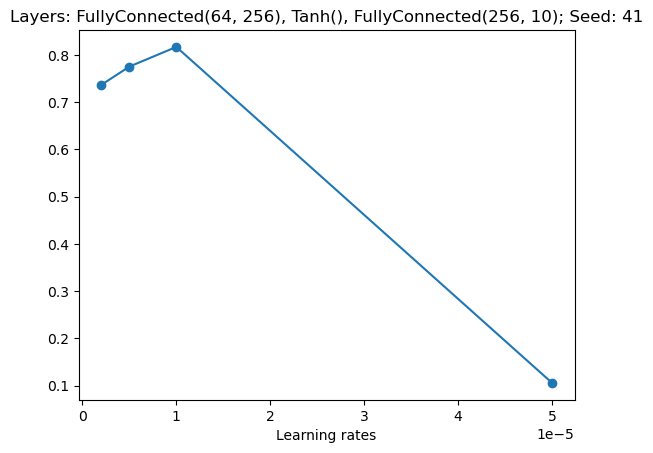

Accuracy: 0.10555555555555556
Accuracy: 0.35833333333333334
Accuracy: 0.25555555555555554
Accuracy: 0.22777777777777777


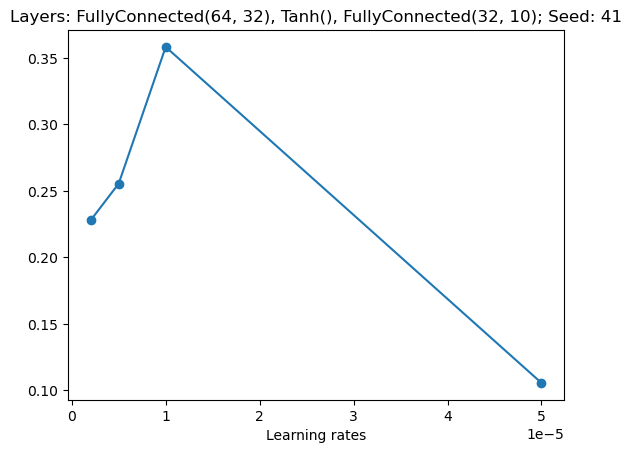

Accuracy: 0.044444444444444446
Accuracy: 0.06944444444444445
Accuracy: 0.15
Accuracy: 0.044444444444444446


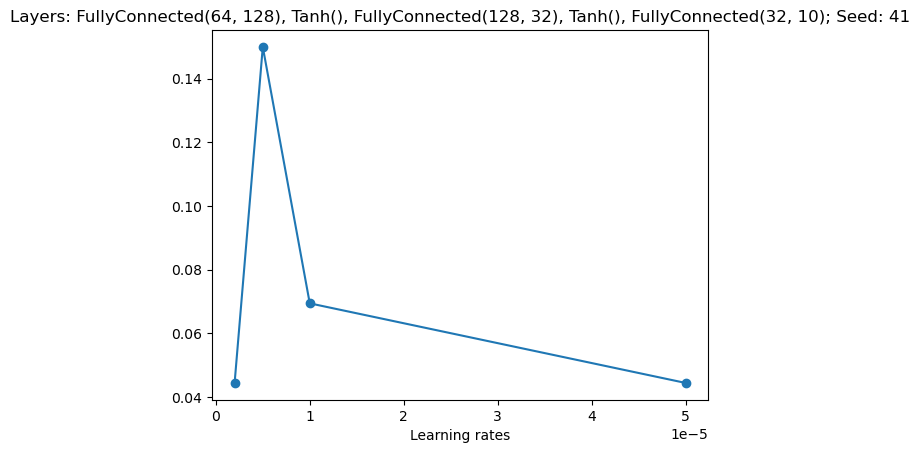

Accuracy: 0.09166666666666666
Accuracy: 0.7805555555555556
Accuracy: 0.8027777777777778
Accuracy: 0.8361111111111111


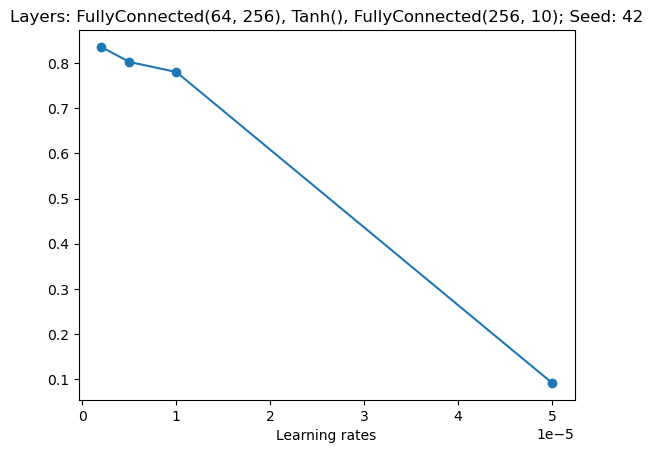

Accuracy: 0.09166666666666666
Accuracy: 0.43333333333333335
Accuracy: 0.25833333333333336
Accuracy: 0.20277777777777778


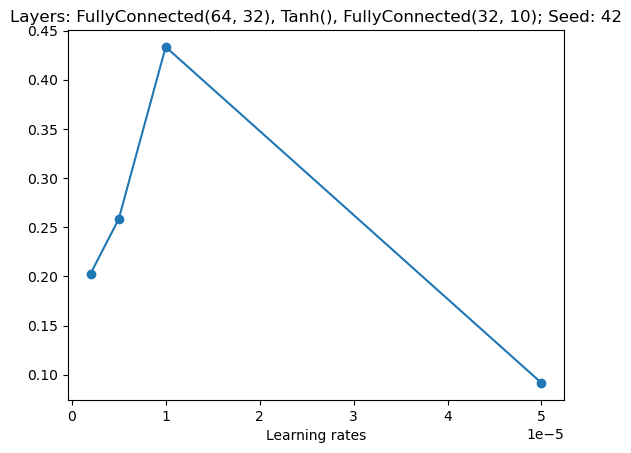

Accuracy: 0.10555555555555556
Accuracy: 0.18333333333333332
Accuracy: 0.025
Accuracy: 0.019444444444444445


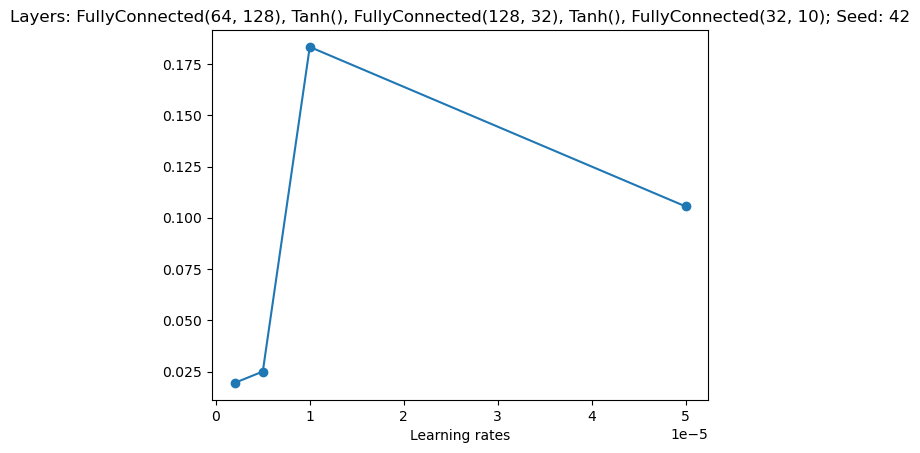

Accuracy: 0.11666666666666667
Accuracy: 0.7694444444444445
Accuracy: 0.8111111111111111
Accuracy: 0.7305555555555555


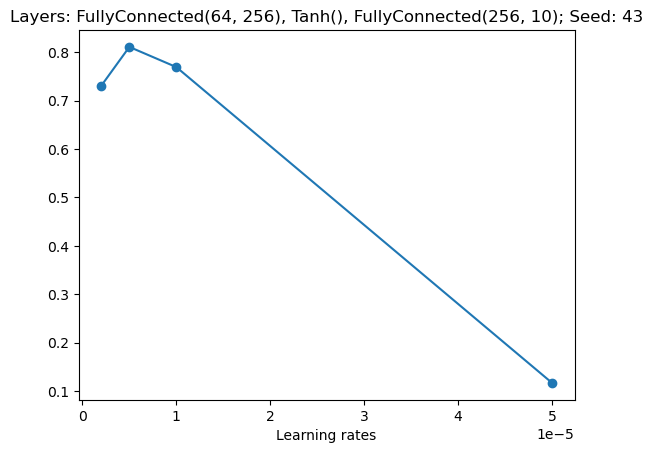

Accuracy: 0.5111111111111111
Accuracy: 0.42777777777777776
Accuracy: 0.2611111111111111
Accuracy: 0.18333333333333332


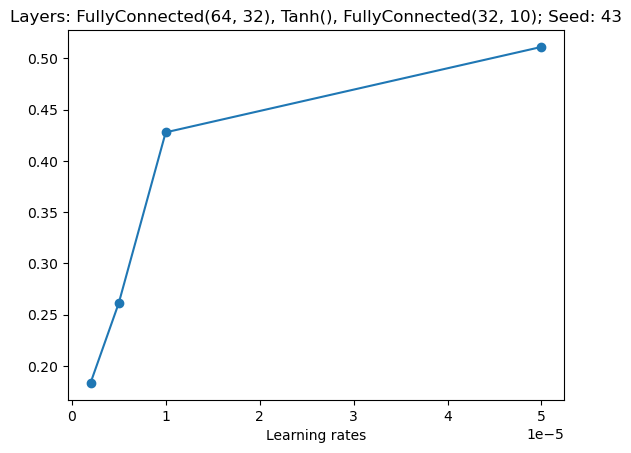

Accuracy: 0.09722222222222222
Accuracy: 0.1527777777777778
Accuracy: 0.1361111111111111
Accuracy: 0.030555555555555555


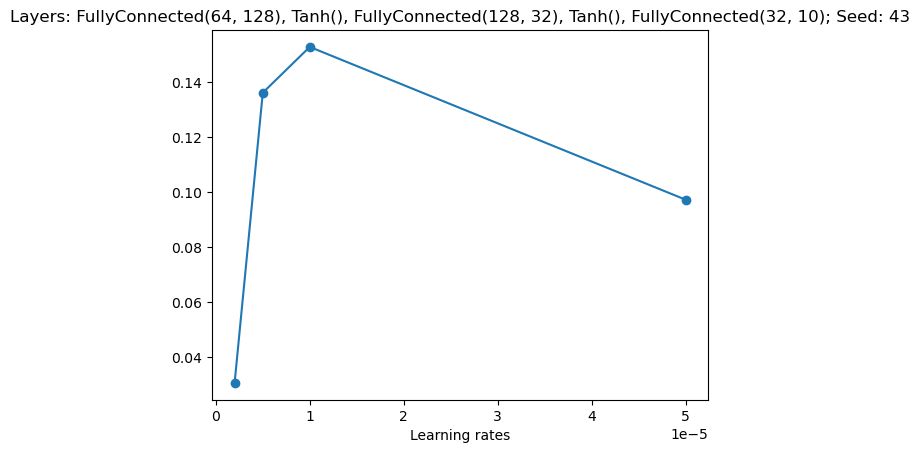

In [217]:

learning_rates = [0.00005, 0.00001, 0.000005, 0.000002]


seeds = [41, 42, 43]

for seed in seeds:

    for i in range(3):
        accuracies = []
        for l_rate in learning_rates:
            digits = load_digits()
            X, y = digits.data, digits.target
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

            # Standardize the data
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            #one-hot encoding
            y_train_one_hot = np.eye(10)[y_train]
            if i == 0:
                layers = [FullyConnected(64, 256), Tanh(), FullyConnected(256, 10)]
                layers_str = 'FullyConnected(64, 256), Tanh(), FullyConnected(256, 10)'
            elif i == 1:
                layers = [FullyConnected(64, 32), Tanh(), FullyConnected(32, 10)]
                layers_str = 'FullyConnected(64, 32), Tanh(), FullyConnected(32, 10)'
            else:
                layers = [FullyConnected(64, 128), Tanh(), FullyConnected(128, 32), Tanh(), FullyConnected(32, 10)]
                layers_str = 'FullyConnected(64, 128), Tanh(), FullyConnected(128, 32), Tanh(), FullyConnected(32, 10)'
            network = Network(layers=layers, learning_rate=l_rate)
            network.compile(loss=MeanSquaredErrorLoss)
            network.fit(X_train, y_train_one_hot, epochs=10, verbose=0)

            predictions = np.argmax(network(X_test), axis=1)
            accuracy = np.mean(predictions == y_test)
            accuracies.append(accuracy)
            print(f"Accuracy: {accuracy}")
            del layers

        plt.plot(learning_rates, accuracies)
        plt.scatter(learning_rates, accuracies)
        plt.title(f'Layers: {layers_str}; Seed: {seed}')
        plt.xlabel("Learning rates")
        plt.show()

Wnioski:

Sieci uzyskują skrajnie różne dokładności klasyfikacji w zależności od architektury oraz od wartości parametru learning_rate. Najlepsze wartości uzyskiwane są dla połączenia 2 warstw FullyConnected o większej ilości neuronów tj. wartość 256 dawała lepsze rezultaty niż np. 64 wraz z przekształceniem z tangensem hiperbolicznym. Dodatkowo nawet w ramach jednej architektury wybór parametru learning_rate może diametralnie zmienić wyniki, w szczególności widać to na 1. wykresie. Problemem jest również inicjalizacja wag tj. dla niektórych uruchomień sieci, która uzyskiwała zazwyczaj dobre rezultaty, otrzymywane były niskie wskaźniki jakości. Stąd można byłoby zaimplementować inny sposób doboru początkowych wag. 
Zdecydowałem się skorzystać z prostej implementacji gradientu tj. jego stochastycznej wersji bez inercji, zaś opcja z inercją również mogłaby pozwolić na uzyskanie zauważalnie lepszych dokładności klasyfikacji.